In [4]:
import numpy as np
import pandas as pd
import datetime as dt
import datapackage
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import statsmodels.api as sm
import statsmodels.tsa.vector_ar.vecm as vecm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as ts

## testing armington elastcities UK gas market ##

url = 'https://raw.githubusercontent.com/joe-ascroft/phd/master/data/CPI_CCCI_test.csv'
df = pd.read_csv(url)

In [5]:
print(df)

       Date   CPI  CCCI
0   1/12/13  1.10   0.8
1   1/03/14  1.24   0.4
2   1/06/14  1.22   0.5
3   1/09/14  1.13   1.2
4   1/12/14  1.72   0.6
5   1/03/15  0.81   0.8
6   1/06/15  1.53   0.6
7   1/09/15  1.36   1.0
8   1/12/15  1.20   0.5
9   1/03/16  0.84   0.8
10  1/06/16  2.08   0.3
11  1/09/16  2.04   0.7
12  1/12/16  1.40   0.9
13  1/03/17  0.99   1.7
14  1/06/17  1.82   1.9
15  1/09/17  1.09   1.8
16  1/12/17  1.30   1.1
17  1/03/18  0.39   1.1
18  1/06/18  1.07   1.0
19  1/09/18  1.25   1.1
20  1/12/18  0.86   1.3
21  1/03/19  0.66   1.3
22  1/06/19  0.66   0.6
23  1/09/19  0.56   1.0
24  1/12/19  0.46   0.9
25  1/03/20  1.01   1.0
26  1/06/20  0.73   1.0
27  1/09/20  0.27   0.6
28  1/12/20  1.26   0.4
29  1/03/21  1.16   1.3
30  1/06/21  4.58   2.2
31  1/09/21  4.55   1.6
32  1/12/21  4.59   0.9
33  1/03/22  3.47   2.4
34  1/06/22  4.54   2.6


                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     13.05
Date:                Sun, 16 Oct 2022   Prob (F-statistic):           0.000996
Time:                        16:38:45   Log-Likelihood:                -50.691
No. Observations:                  35   AIC:                             105.4
Df Residuals:                      33   BIC:                             108.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3160      0.391      0.809      0.4

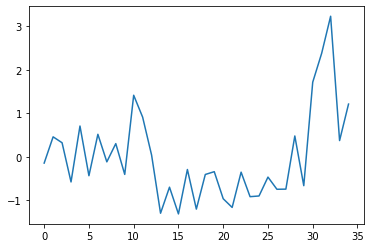

In [6]:
result1 = smf.ols(formula="CPI ~ CCCI", data=df).fit()
print(result1.summary())
plt.plot(result1.resid)

In [7]:
test = ts.adfuller(result1.resid,autolag="AIC")
print(test)

(-3.084948375301031, 0.027687314760578986, 0, 34, {'1%': -3.639224104416853, '5%': -2.9512301791166293, '10%': -2.614446989619377}, 68.7452219438726)


In [8]:
lag_order1 = vecm.select_order(data=df[['CPI', 'CCCI']], maxlags=5, deterministic="ci")
print(lag_order1.selected_orders)

{'aic': 2, 'bic': 0, 'hqic': 0, 'fpe': 2}


In [19]:
m1 = vecm.VECM(df[['CPI', 'CCCI']], deterministic="ci", k_ar_diff=2, coint_rank=1)  
vecm_res_1 = m1.fit()
vecm_res_1.summary()

,coef,std err,z,P>|z|,[0.025,0.975]
L1.CPI,-0.0991,0.220,-0.451,0.652,-0.530,0.332
L1.CCCI,0.6872,0.282,2.441,0.015,0.135,1.239
L2.CPI,0.1543,0.181,0.853,0.393,-0.200,0.509
L2.CCCI,-0.1667,0.348,-0.479,0.632,-0.848,0.515
,coef,std err,z,P>|z|,[0.025,0.975]
L1.CPI,-0.1942,0.124,-1.561,0.119,-0.438,0.050
L1.CCCI,0.1245,0.159,0.782,0.434,-0.188,0.437
L2.CPI,-0.3021,0.102,-2.954,0.003,-0.503,-0.102
L2.CCCI,-0.1289,0.197,-0.655,0.512,-0.514,0.257
,coef,std err,z,P>|z|,[0.025,0.975]


In [11]:
granger_results = vecm_res_1.test_granger_causality(caused="CPI", signif=0.05)
granger_results.summary()

Test statistic,Critical value,p-value,df
4.437,2.816,0.008,"(3, 44)"
